In [160]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML
import numpy as np
import math
from math import inf
from datetime import datetime,timedelta
import warnings

OGGM Climate Source: GSWP3_W5E5

1984 extent: 3251 meters
This was calculated by measuring the length of the glacier along the centerline on a polygon of the glacier from 1958. Then extent change date from FoG_FVobs_205.csv was used to calculate the change in extent from 1958-1984

In [161]:
class glacierSim():
    def __init__(self, ela=1880,ela_1900=1650,valley_length=3668, time=500,save=10,gamma=0.01,quiet=True, tune_factors=[-0.004,-0.002,0.0065,1.6,2.2,5,0.006], initial_ice=None, start_time=0):
        #MODEL VARS:
        self.valley_length = valley_length
        self.start_ela = ela #in m
        self.curr_ela=ela
        self.ela_1900=ela_1900
        self.num_cells = 50 #set number of cells
        self.dx = self.valley_length/(self.num_cells-1) #cell width in m
        if start_time==0: self.ice = np.zeros(self.num_cells) #initialize ice
        else: self.ice = np.array(initial_ice)
        
        #PLOTTING VARS:
        self.ice_line_list=[] #stores info for plotting ice
        self.snow_line_list=[] #stores info for plotting snow
        self.ela_line_list=[] #stores info for plotting ela
        self.title_list=[] #stores info for plotting title
        self.x = np.linspace(0.5 * self.dx, self.valley_length - 0.5 * self.dx,self.num_cells) #used for plotting topography and ice thickness
        self.topo =[] #initialize topography
        self.quiet=quiet #set to true to printout values while model is running
        
        #ICE FLUX VARS:
        self.q = np.zeros(self.num_cells+1) #initialize ice flux, need to have num_cells+1 to offset it from ice thickness for calculations
        self.g = 9.81 #gravity constant in m/yr^2
        self.p = 917 #density of ice
        self.ice_slope = np.zeros(self.num_cells) #initialize ice_slope
        
        #TIME VARS:
        self.run_time=start_time*365.25 #DAYS
        self.prev_display=0 #used for displaying model data while running when quiet=false
        self.time = time #simulation time in years
        self.current_date=datetime(1484,1,1)+timedelta(days=start_time*365.25)
        self.save = save*365.25 #timestep interval in days
        self.frames = ((int)((self.time-start_time)/(self.save/365.25)))+1 #number of frames the animation will run for
        self.timestep_list=[] #days
        
        #MASS BALANCE VARS:
        self.b_max = float(-inf) #maximum yearly mass balance value for whole run
        self.b_min = float(inf) #minimum yearly mass balance valeu for whole run
        self.gamma = gamma #for mass balance equation
        self.b=np.zeros(self.num_cells) #initialize mass balance
        self.snow_depth=np.zeros(self.num_cells) #snow depth along glacier in m
        self.snow_melt_amt=np.zeros(self.num_cells) #snow melt amount in m
        self.weather_dates=[] #dates for weather data
        self.temps=[] #daily temperatures
        self.precip=[] #daily precipitation
        
        #TUNE FACTORS:
        self.ice_melt_factor=tune_factors[0] #factor to change how much the ice melts per degree C
        self.snow_melt_factor=tune_factors[1] #factor to change how much the snow melts per degree C
        self.temp_lapse_rate=tune_factors[2] #temp lapse rate in C/m]
        self.accumfactor_lower=tune_factors[3] #lower bound to change how much snow gets turned into ice
        self.accumfactor_upper=tune_factors[4] #upper bound to change how much snow gets turned into ice
        self.snow_conv_factor=tune_factors[5] #factor to change how much precip gets turned to snow
        self.precip_conv_factor=tune_factors[6] #precipitation lapse rate in m/m
        
        #VERIF VARS:
        self.annual_mb=[] #annual mass balance verif data
        self.winter_mb=[] #winter (positive) mass balance verif data
        self.summer_mb=[] #summer (negative) mass balance verif data
        self.thickness_change_verif=np.zeros(4) #thickness change for verif
        self.front_variation_verif=np.zeros(100) #front variation verification data
        self.ela_verif=np.zeros(100) #ela's for verification
        self.measured_runoff_training=[] #holds daily runoff data for training
        self.measured_runoff_verif=[] #holds daily runoff data for verification
        self.measured_runoff_all=[]
        self.thickness_1986_verif=0 #thickness in 1986 for verif
        self.thickness_2021_verif=0 #thickness in 2021 for verif
        self.date_index_training=[] #holds date index for training data
        self.date_index_verif=[] #holds date index for verification data
        self.date_index_all=[] #holds date index for all data
        self.precip_accum=np.zeros(41)
        
        #CALCULATED VERIF VARS:
        self.calculated_annual_mb=np.zeros(40, dtype=np.float64) #used to verify annual mass balance
        self.calculated_winter_mb=np.zeros(40, dtype=np.float64) #used to verify winter (positive) mass balance
        self.calculated_summer_mb=np.zeros(40, dtype=np.float64) #used to verify summer (negative) mass balance
        self.front_variation_calc=np.zeros(100) #model calculated front variation
        self.thickness_change=np.zeros(4) #model thickness change
        self.year_mb=np.zeros(len(self.b)) #keeps track of the mb for the current year to calculate ela line
        self.ice_1986=np.zeros(self.num_cells) #stores the ice in 1986
        self.ice_volume=0 #volume of glacier in m^3
        self.glacial_melt=0
        self.rain_vol_per_step=0
        self.snow_melt_vol=0 #volume of melted snow in m^3, used to factor in snowmelt to volume calculations for stream flow data comparisons
        self.glacier_extent=0 #length of glacier in m
        self.ela_list=[] #list of ela values over time, used for verif
        self.ice_thickness_over_time=[] #tracks avg ice thickness over time
        self.daily_runoff_training=[] #holds daily runoff data for training
        self.daily_runoff_verif=[] #holds daily runoff data for verification
        self.daily_runoff_all_data=[]
        self.monthly_runoff_all=np.zeros((self.time-start_time)*12+1) #holds daily runoff data for all data
        self.monthly_glacier_melt=np.zeros((self.time-start_time)*12+1) #holds daily runoff data for all data
        self.snow_depth_list=[]
        
        #PREV VARS:
        self.prev_thickness=np.mean(self.ice) #previous avg ice thickness used to calculate thickness change
        self.prev_front=np.max(self.x[self.ice>1]) if np.any(self.ice>1) else 0 #previous front location to calculate front var change
        
        #WIDTH VARS:
        self.bins=[] #elevation bins for widths
        self.years=[] #years for width data
        self.areas=[] #area of glacier in m^2, used to calculate width
        self.year_area=np.zeros(self.num_cells)
        self.glacier_area=0
        self.year_area_list=[]
        self.area_list=[]
        self.snow_bin_aspect=[]
        
    def init(self, ax,ela=1880,ela_1900=1650,valley_length=3668, time=500,save=10,gamma=0.008, quiet=True, tune_factors=[-0.004,-0.002,0.0065,1.6,2.2,5,0.006], initial_ice=None, start_time=0):
        self.__init__(ela, ela_1900,valley_length, time, save, gamma, quiet, tune_factors, initial_ice, start_time)
        self.load_verif_data()
        self.calc_topo()
        self.calc_areas()
        self.load_mb_data()
        try: curr_ela=self.topo[np.where((self.b[:-1] >= 0) & (self.b[1:] < 0))[0]][0]
        except: curr_ela=self.topo[-1]
        self.ela_list.append(curr_ela)

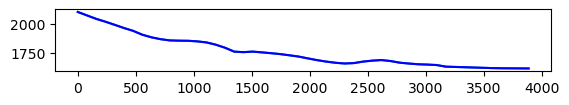

In [162]:

class glacierSim(glacierSim):
    def haversine(self, lat1, lon1, lat2, lon2):
        a = math.sin(math.radians(lat2 - lat1) / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos( math.radians(lat2)) * math.sin(math.radians(lon2 - lon1) / 2) ** 2
        return 6371000*(2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
        
    def calc_topo(self):
        latitudes = []
        longitudes = []
        topo = []
        df = pd.read_csv('Data/centerlineBed.csv')
        latitudes = df.iloc[:, 2].astype(float).tolist()  # Latitude is the second column (index 2)
        longitudes = df.iloc[:, 1].astype(float).tolist()  # Longitude is the third column (index 1)
        topo = df.iloc[:, 0].astype(float).tolist()  # Elevation is the first column (index 0)
        cumulative_distances=[0.0]
        for i in range(1, len(latitudes)): cumulative_distances.append(cumulative_distances[-1] + self.haversine(latitudes[i - 1], longitudes[i - 1], latitudes[i], longitudes[i]) )
        self.x=np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells) #creates self.x values
        self.topo=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, topo) #interpolates bed topo to get elevations at self.x values
        self.valley_length=np.max(self.x)
        self.dx = self.valley_length/(self.num_cells-1) #re-initializes dx using updates valley length
        self.ice_slope[:-1] = abs((np.diff(self.topo)/ self.dx)) #initial ice slope is just topo slope
        #THIS CREATES A FAKE INITIAL ICE FOR ICE FLUX TESTING
        #self.ice=np.exp(-0.5 * ((self.x - 700) / 300) ** 2)
        #scale=300/np.max(self.ice)
        #self.ice*=scale
        data_1986 = np.loadtxt('Data/centerlineThickness_1986.csv', delimiter=',', skiprows=1)
        self.thickness_1986_verif = data_1986[:, 3] - data_1986[:, 0]
        data_2021 = np.loadtxt('Data/centerlineThickness_2021.csv', delimiter=',', skiprows=1)
        self.thickness_2021_verif = data_2021[:, 3] - data_2021[:, 0]
        self.thickness_1986_verif=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_1986_verif) if type(self.thickness_1986_verif) is not int else np.zeros(self.num_cells)
        self.thickness_2021_verif=np.maximum(np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_2021_verif) if type(self.thickness_2021_verif) is not int else np.zeros(self.num_cells),0)
        
    def calc_areas(self):
        df = pd.read_csv('Data/Input_SouthCascade_Area_Altitude_Distribution.csv')
        self.bins = df.columns[2:].astype(float).to_numpy()
        self.years = df.iloc[:, 0].astype(float).tolist()
        self.areas = df.iloc[:, 2:].astype(float).values*1000000
        self.bin_bounds=np.concatenate(([self.bins[0] - 25], (self.bins[:-1] + self.bins[1:]) / 2, [self.bins[-1] + 25]))
        area=self.areas[0,:]
        bin_indices = np.digitize((self.topo+self.ice), self.bins)
        for i in range(len(area)):
            mask = (bin_indices == i)
            cell_indices = np.where(mask)[0]
            n_cells = len(cell_indices)
            if n_cells > 0:
                base_area = area[i] / n_cells
                self.year_area[mask] = base_area
                self.year_area[cell_indices[0]] += (area[i] - (base_area * n_cells))
        if np.sum(self.year_area)<np.sum(area): self.year_area+=(np.sum(area)-np.sum(self.year_area))/len(self.year_area)
        if round(np.sum(self.year_area))!=round(np.sum(area)):
            print("Warning: Year area does not equal area")
            print("Year area: ", round(np.sum(self.year_area)))
            print("Area: ", round(np.sum(area)))
            print("Difference: ", round(np.sum(self.year_area)-np.sum(area)))
                
    def update_areas(self):
        area=self.areas[(self.current_date.year-1950),:]
        bin_indices = np.digitize((self.topo+self.ice), self.bins)
        for i in range(len(area)):
            mask = (bin_indices == i)
            cell_indices = np.where(mask)[0]
            n_cells = len(cell_indices)
            if n_cells > 0:
                base_area = area[i] / n_cells
                self.year_area[mask] = base_area
                self.year_area[cell_indices[0]] += (area[i] - (base_area * n_cells))
        if np.sum(self.year_area)<np.sum(area): self.year_area+=(np.sum(area)-np.sum(self.year_area))/len(self.year_area)
        if round(np.sum(self.year_area))!=round(np.sum(area)):
            print("Warning: Year area does not equal area")
            print("Year area: ", round(np.sum(self.year_area)))
            print("Area: ", round(np.sum(area)))
            print("Difference: ", round(np.sum(self.year_area)-np.sum(area)))
        
glac=glacierSim()
glac.calc_topo()
glac.calc_areas()
plt.plot(glac.x, glac.topo)
plt.plot(glac.x,glac.ice+glac.topo, color='b')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

8/15/1997 to 7/15/2001 inclusive is used as runoff training data and the rest is used for verification

In [ ]:

class glacierSim(glacierSim):
    def load_mb_data(self):
        df = pd.read_csv('Data/Input_SouthCascade_Daily_Weather.csv')
        self.dates = pd.to_datetime(df.iloc[:, 0], format="%Y/%m/%d").tolist()
        self.temps = df.iloc[:, 1].astype(float).to_numpy()
        self.precip = df.iloc[:, 2].apply(lambda x: float(x) if not np.isnan(float(x)) else 0).to_numpy()
        #MAKE NOTE OF THIS IN THESIS, SOME OF THE TEMPERATURE DATA IS INTERPOLATED BECAUSE ITS MISSING
        nan_indices = np.isnan(self.temps)
        x = np.arange(len(self.temps))
        self.temps[nan_indices] = np.interp(x[nan_indices], x[~nan_indices], self.temps[~nan_indices])

    def load_verif_data(self):
        df = pd.read_csv('Data/Output_SouthCascade_Glacier_Wide_solutions_calibrated.csv', skiprows=25)
        self.annual_mb = df.iloc[:-1, 3].astype(float).tolist()
        self.summer_mb = df.iloc[:-1, 2].astype(float).tolist()
        self.winter_mb = df.iloc[:-1, 1].astype(float).tolist()
        self.ela_verif=df.iloc[5:, 4].astype(float).to_numpy()
        self.calculated_annual_mb=np.array([0] * len(self.annual_mb), dtype=np.float64)
        self.calculated_winter_mb=np.array([0] * len(self.winter_mb), dtype=np.float64)
        self.calculated_summer_mb=np.array([0] * len(self.summer_mb), dtype=np.float64)
        df = pd.read_csv('Data/runoff_m3_1992-2007.csv')
        df['date'] = pd.to_datetime(df['date'])
        start_date = "1997-08-15"
        end_date = "2001-07-15"
        training_data = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
        self.measured_runoff_training = training_data.groupby(training_data["date"].dt.to_period("M"))["runoff"].sum().to_numpy()
        self.date_index_training = {date: idx for idx, date in enumerate(training_data['date'])}
        self.daily_runoff_training = np.zeros(len(self.date_index_training))
        verif_data = df[(df["date"] < start_date) | (df["date"] > end_date)]
        self.measured_runoff_verif = verif_data.groupby(verif_data["date"].dt.to_period("M"))["runoff"].sum().to_numpy()
        self.date_index_verif = {date: idx for idx, date in enumerate(verif_data['date'])}
        self.daily_runoff_verif = np.zeros(len(self.date_index_verif))
        self.date_index_all = {date: idx for idx, date in enumerate(df['date'])}
        self.measured_runoff_all = df.groupby(df['date'].dt.to_period('M'))['runoff'].sum().to_numpy()
        self.daily_runoff_all_data = np.zeros(len(self.date_index_all))
        self.thickness_change_verif = pd.read_csv('Data/thickness_change.csv').iloc[0:, 11].astype(float).to_numpy()
        self.front_variation_verif = pd.read_csv('Data/front_variation_change.csv').iloc[0:, 9].astype(float).to_numpy()
        self.front_variation_calc = np.zeros(len(self.front_variation_verif))
        self.snow_areas, self.mean_snow_bin_elev=np.loadtxt('Data/basin_wide_area_elev_bands.csv', delimiter=',', usecols=(1, 2), unpack=True)
        self.snow_depth=np.zeros(len(self.snow_areas))
        self.snow_melt_amt=np.zeros(len(self.snow_areas))
        self.snow_bin_aspect=np.loadtxt('Data/avg_basin_bin_aspect.csv', delimiter=',')
        
    def calc_verif(self,timestep):
        #Round current date since all of the lists are based on day or year
        current_date_key = self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)
        #These are the days before the start dates for the volume verif data so need to set the pre_volume to calculate Runoff
        # if current_date_key==datetime(2002,9,30) or  current_date_key==datetime(2003,6,8): self.prev_volume=self.ice_volume.copy()
        #If date is in the list of volume verification dates, calculate the Runoff
        if current_date_key in self.date_index_all: self.daily_runoff_all_data[self.date_index_all[current_date_key]] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        if current_date_key in self.date_index_training: self.daily_runoff_training[self.date_index_training[current_date_key]] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        if current_date_key in self.date_index_verif: self.daily_runoff_verif[self.date_index_verif[current_date_key]] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        self.monthly_runoff_all[(self.current_date.year - 1984) * 12 + (self.current_date.month - 1)] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        self.monthly_glacier_melt[(self.current_date.year - 1984) * 12 + (self.current_date.month - 1)] += self.glacial_melt
        #If date is the date before thickness change verification data starts then set prev_thickness to calculate thickness change
        if self.current_date==datetime(1998,12,31): self.prev_thickness=np.mean(self.ice)
        #Calculate thickness change data
        if 1999 <= self.current_date.year < 2004:
            avg_thickness=np.mean(self.ice)
            self.thickness_change[0]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        elif 2004 <= self.current_date.year < 2009: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[1]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        elif 2009 <= self.current_date.year < 2014: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[2]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        if 2014 <= self.current_date.year < 2019: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[3]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        #If date is the date before front variation change verification data starts then set prev_front to calculate front variation change
        if self.current_date==datetime(1983,12,31): self.prev_front=np.max(self.x[self.ice > 1])
        #Calculate front variation data
        if 1984<=self.current_date.year<2009:
            if np.any(self.ice>1):
                self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-np.max(self.x[self.ice > 1])
                self.prev_front=np.max(self.x[self.ice > 1])
            else:
                self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-self.x[0]
                self.prev_front=self.x[0]
        #Calcualte ice thickness data for 1986
        if self.current_date.year==1986: self.ice_1986=self.ice[~np.isnan(self.thickness_1986_verif)].copy()
        #Add mass balance to verification arrays
        if 1984<=self.current_date.year<2024:
            date=int(self.current_date.year-1984)
            self.calculated_annual_mb[date]+=np.mean(np.array(self.b*timestep)) if self.b.size>0 else 0
            self.calculated_winter_mb[date]+=np.mean(np.array(self.b[self.b>0]*timestep)) if self.b[self.b>0].size>0 else 0
            self.calculated_summer_mb[date]+=np.mean(np.array(self.b[self.b<0]*timestep)) if self.b[self.b<0].size>0 else 0
        #Make sure mass balance verification arrays are correct
        if np.any(self.calculated_winter_mb<0): print("ERROR IN WINTER MB")
        if np.any(self.calculated_summer_mb>0): print("ERROR IN SUMMER MB")
    
    def snow_model(self, index,timestep):
        if type(self.temp_lapse_rate) is int: snow_temps=self.temps[index]+self.temp_lapse_rate*(self.mean_snow_bin_elev-272)
        else: snow_temps=self.temps[index]+self.temp_lapse_rate[self.current_date.month-1]*(self.mean_snow_bin_elev-272)
        self.snow_depth[snow_temps<=0]+=(self.precip[index]/1000*self.precip_conv_factor)*timestep
        self.snow_melt_amt.fill(0)
        self.snow_melt_amt[snow_temps>0]=self.snow_melt_factor*snow_temps[snow_temps>0]*timestep
        self.snow_melt_amt=-np.minimum(np.abs(self.snow_melt_amt),self.snow_depth)
        if np.any(self.snow_melt_amt>0): print("SNOW MELT POSITIVE")
        self.snow_depth+=self.snow_melt_amt
        self.snow_melt_vol=np.sum(np.abs(self.snow_melt_amt[:-1])*np.maximum((self.snow_areas[:-1]-self.areas[(self.current_date.year-1950),:]),0))+(np.abs(self.snow_melt_amt[-1])*self.snow_areas[-1])
        self.rain_vol_per_step=np.sum((self.precip[index]/1000*self.precip_conv_factor)*timestep*(self.snow_areas[snow_temps>0]))
        # print(np.mean(self.snow_depth))
        # print(self.snow_melt_vol)
        self.snow_depth_list.append(np.mean(self.snow_depth))
        if self.snow_melt_vol<0: print("NEGATIVE SNOW MELT")

    def update_b(self, timestep):
        if self.current_date>=datetime(1984,1,2):
            #Calculate which index to get weather data from
            if self.current_date<datetime(2024,10,1): index=self.dates.index(pd.Timestamp(self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)))
            else: index=self.dates.index(pd.Timestamp(datetime(2024, 9, 30)))
            #Calculates temperatures for every self.x value and varies temp with elevation
            if type(self.temp_lapse_rate) is int: x_temps=self.temps[index]+self.temp_lapse_rate*(self.ice+self.topo-272) #weather station elevation is 272m
            else: x_temps=self.temps[index]+self.temp_lapse_rate[self.current_date.month-1]*(self.ice+self.topo-272)
            mb=np.zeros_like(x_temps) #initialize mass balance
            #Melts ice for temps greater than 0
            melt_arr=self.snow_melt_factor+((self.curr_ela-(self.ice+self.topo))/(self.curr_ela-np.nanmin(self.topo+self.ice)))*(self.ice_melt_factor-self.snow_melt_factor)
            melt_arr[melt_arr<self.ice_melt_factor]=self.ice_melt_factor
            mb[np.where((x_temps>0)&((self.ice+self.topo)>=self.curr_ela))[0]]=self.snow_melt_factor*x_temps[np.where((x_temps>0)&((self.ice+self.topo)>self.curr_ela))[0]]
            mb[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]=melt_arr[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]*x_temps[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]
            #Calculates snow melt and accumulation
            self.snow_model(index,timestep)
            # accumulation gradient
            accumfactor = self.accumfactor_lower + ((self.current_date.year - 1984) / (2024 - 1984)) * (self.accumfactor_upper-self.accumfactor_lower)
            mb[x_temps<0]=self.precip[index]/1000*self.precip_conv_factor*accumfactor*timestep
            self.glacial_melt=np.sum(np.abs(mb[mb<0])*self.year_area[mb<0])*timestep
            self.precip_accum[self.current_date.year-1984]+=np.sum((self.precip[index]/1000)*self.precip_conv_factor*timestep)
            #Alert for weird mass balance values
            if np.any(mb[x_temps<0]<0): print("NEGATIVE MB", mb[x_temps<0])
            if np.any(np.isnan(mb[x_temps < 0])): print("NAN MB", self.precip[index])
            if np.any(np.abs(mb)>100): print("MB TOO BIG",mb)
            return mb
        else: 
            #Used to spin up the glacier. Glacier starts retreating in 1900
            return ((self.topo+self.ice-self.curr_ela)*self.gamma)/365.25 #meters per day

In [164]:
class glacierSim(glacierSim):
    def calc_q(self):
        #Calculate ice clops
        self.ice_slope[:-1] = -(np.diff(self.ice+self.topo) / self.dx)
        #Check for weird ice and ice_slope values
        if np.any(np.isnan(self.ice_slope)): #and not self.quiet:
            print('NaN detected in ice_slope:', self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("TIME: ", self.run_time)
            plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if np.any(np.isnan(self.ice)): #and not self.quiet:
            print('NaN detected in ice:', self.ice)
            print("TIME: ", self.run_time)
            return
        if np.any(np.isinf(self.ice_slope)): # and not self.quiet:
            print('Infinity detected in ice_slope:', self.ice_slope)
            print('Ice: ',self.ice)
            print("Q: ",self.q)
            print("TIME: ", self.run_time)
            plt.plot(self.timestep_list)
            return
        #Calculate ice flux
        #self.q[1:] = (0.2 *(2e-17*2) * (self.p * self.g)**2) * np.sin(np.arctan(self.ice_slope))**2 * (self.ice**5)/5
        #self.q[1:]=2e-17* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #YEARS
        self.q[1:]=5.87e-19* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #DAYS
        #Check for weird q values
        if np.any(np.isnan(self.q)): #and not self.quiet:
            print('NaN detected in q:', self.q)
            print(self.ice_slope)
            print(self.ice)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        #Print model status every self.save years if quiet is false
        if (self.prev_display==0.0 or ((self.run_time>=(self.prev_display+(self.save/365.25))*365.25) and self.run_time<(self.time*365.25))) and not self.quiet:
            print("TIME: ", math.floor(self.run_time/365.25))
            print("ELA: ", self.curr_ela)
            print("ICE: ",self.ice)
            print("SLOPE: ",self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("Q: ",self.q)
            print("DQDX: ",np.diff(self.q)/self.dx)
            print("SUM Q: ", np.sum(self.q))
            print("SUM DQDX: ",np.sum(np.diff(self.q)/self.dx))
            print()
            self.prev_display=self.run_time/365.25
        #Calculate the change in ice thickness and return it
        return (self.b-(np.diff(self.q)/self.dx)) 

    def report_final_values(self,u):
        ice_extent = self.x[self.ice > 2]
        if ice_extent.size > 0:
            self.glacier_extent=np.max(ice_extent)
            print("Final glacier length: " + str(np.max(ice_extent)) + 'm')
        else: print("Final glacier length: 0m (no ice extent)")
        print("Final max ice thickness: " + str(np.max(self.ice)) + 'm')
        #print('Final max velocity: ' +str(np.max(u)) + "m/yr")
        # if(self.default_b):
        #     print('B min: ' + str(self.b_min))
        #     print('B max: ' + str(self.b_max))

    def run_model(self,i):
        #Used to plot initial values
        if i==0:
            curr_ela_plt=[self.start_ela]*self.num_cells
            self.ice_line_list.append((self.x, self.ice + self.topo, "c", "Ice"))
            # self.snow_line_list.append((self.x, self.snow_depth + self.topo+self.ice, "c", "Snow"))
            self.ela_line_list.append((self.x, curr_ela_plt, "r", "dashed", "ELA"))
            self.title_list.append('Year = ' + str(self.current_date.year))
            return
        iter_time=0.0 #days
        timestep=0.0 #days
        while(iter_time<self.save):
            #End while loop if the difference between the save and current iter_time is less than 1, this is done to make sure it doesn't run over
            if (self.save-iter_time)<1: break
            #Calculate glacier velocity for timestep calculation
            u = (5.87e-19)*((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*(((self.ice)**4)/5)
            #Calculate the timestep based on glacier velocity, the 0.2 multiplier can be changed, increase it to increase the timestep
            #Timestep is constrained between 0.0001 and 1 and rouned to the 5th decimal place, its always 1 though
            timestep = round(np.clip(((self.dx / np.nanmax(u)) * 0.2), 0.0001, 1),4) if np.any(u > 0) else 1
            self.timestep_list.append(timestep)
            self.b=self.update_b(timestep)
            dqdx=self.calc_q()
            #Set new ice thickness
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            # self.ice_volume=np.sum(self.ice*self.dx*self.widths)
            self.ice_volume=np.sum(np.mean(self.ice)*self.year_area)
            #Update time variables
            iter_time+=float(timestep)
            self.run_time+=timestep
            self.current_date+=timedelta(days=float(timestep))
            #Calculate verification data
            self.calc_verif(timestep)
            #Update mass balance for current year
            self.year_mb+=self.b*timestep
            #Set new b_min and b_max
            self.b_max = max(np.max(self.b*365.25),self.b_max)
            self.b_min = min(np.min(self.b*365.25),self.b_min)
            #Update width if width data is available for the current date, updates on the 1st of the year
            if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_areas()
            if self.current_date.year==1900: self.curr_ela=self.ela_1900
        #If this if-statement runs somehow the model ran over which is a problem. The first if statement in the while loop should prevent this
        if(iter_time>self.save):
            print("BROKEN ABORT ABORT", iter_time,self.save)
            return
        #Calculate last ice_flux for this run
        dqdx=self.calc_q()
        #This if statement is also to make sure it doesn't run over. Since self.save should never be a fraction of a year then the current run should always end on 12/31
        if(self.current_date.day!=1):
            #Calculate the timestep so that it doesn't go over
            if(self.current_date.day==31): timestep=float((datetime((self.current_date.year+1),1,1)-self.current_date).total_seconds()/ (24 * 3600))
            else: timestep=float(self.save-iter_time)
            self.timestep_list.append(timestep)
            self.b=self.update_b(timestep)
            #Set new ice thickness
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            # self.ice_volume=np.sum(self.ice*self.dx*self.widths)
            self.ice_volume=np.sum(np.mean(self.ice)*self.year_area)
            #Update time variables
            iter_time+=float(timestep)
            self.run_time+=timestep
            self.current_date+=timedelta(days=float(timestep))
            #Calculate verification data
            self.calc_verif(timestep)
            #Update mass balance for current year
            self.year_mb+=self.b*timestep
            #Set new b_min and b_max
            self.b_max = max(np.max(self.b*365.25),self.b_max)
            self.b_min = min(np.min(self.b*365.25),self.b_min)
            #Update width if width data is available for the current date, updates on the 1st of the year
            if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_areas()
            if self.current_date.year==1900: self.curr_ela=self.ela_1900
        #If the weather data is being used for the mass balance then calculate ela
        if self.current_date.year>=1984:
            #The try-except block is there incase the yearly mass balance is all positive or all negative
            try: curr_ela=float(self.topo[np.where((self.year_mb[:-1] >= 0) & (self.year_mb[1:] < 0))[0][0]])
            except:
                #If the try-except block fails then set ela to the top or bottom of the glacier depending on if the mass balance is all positive or all negative
                if np.all(self.year_mb>0): curr_ela=float(self.topo[0])
                else: curr_ela=float(self.topo[-1])
            #Add to ela list after 1989 because that's when ela verification data starts
            if self.current_date.year>1989: self.ela_list.append(curr_ela)
            #Reset year_mb to 0 for the next year
            self.year_mb.fill(0)
        #Otherwise set ela to the start ela
        else: curr_ela=self.curr_ela
        #Make sure to reset year_mb to 0 on the first of the year
        if self.current_date.month==1 and self.current_date.day==1: self.year_mb.fill(0)
        curr_ela_plt=[curr_ela]*self.num_cells
        #If the current date is the end date then report final values
        if(self.current_date.year==1484+self.time): self.report_final_values(u)
        #Update width if width data is available for the current date, updates on the 1st of the year
        if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_areas()
        #Add data to plotting lists
        self.ice_line_list.append((self.x, self.ice + self.topo, "c", "Ice"))
        # self.snow_line_list.append((self.x, self.snow_depth + self.topo+self.ice, "c", "Snow"))
        self.ela_line_list.append((self.x, curr_ela_plt, "r", "dashed", "ELA"))
        self.title_list.append('Year = ' + str(self.current_date.year))

    #Used to plot the model data after the model has run
    def func(self,i):
        ax.clear() # Remove this to make lines stack up
        ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
        ax.set_xlim(0, float(self.valley_length))
        ax.set_ylabel("Height (m)")
        ax.set_xlabel("Distance (m)")
        ax.set_aspect('equal', adjustable='datalim')
        ax.plot(self.x, self.topo, color="b", label="Topography")
        ax.set_title(self.title_list[i])
        self.ela_line=ax.plot(self.ela_line_list[i][0],self.ela_line_list[i][1], color=self.ela_line_list[i][2], linestyle=self.ela_line_list[i][3], label=self.ela_line_list[i][4])
        self.ice_line=ax.plot(self.ice_line_list[i][0],self.ice_line_list[i][1], color=self.ice_line_list[i][2], label=self.ice_line_list[i][3])
        # self.snow_line=ax.plot(self.snow_line_list[i][0],self.snow_line_list[i][1], color=self.snow_line_list[i][2], label=self.snow_line_list[i][3])
        ax.legend()
        return self.ice_line_list,self.ela_line_list    

#Initialize plotting stuff outside of class
fig, ax = plt.subplots() #initialize plotting variables
_ = plt.close(fig) #used to prevent an empty plot from displaying

In [165]:
ela=1880
ela_1900=1930
time=540
start_time=500
save=1 #Needs to be 1 for the ela_list to work properly
gamma=0.016
quiet=True
#Note: One of the papers I found had snow_meltfactor around 0.004 and ice_meltfactor around 0.006. 
# This is in meters water equivalent per positive degree day, NOT PER DEGREE C
# accumfactor=0.0319 #bounds approx 0.001-0.005
# accumfactor=1.7
#Brute force optimized: 1.04, 2.69
accumfactor_lower=0.66
accumfactor_upper=1.7
#-0.0035 for both minimizes summer mb diff
#Brute force optimized: -0.0039,-0.0024
ice_meltfactor= -0.0039 #bounds approx 0.005-0.012
snow_meltfactor=-0.0025 #bounds approx 0.002-0.006
#Nelder-Mead optimized: 3.53
# snow_conv_factor=3.53#bounds 5-15
snow_conv_factor=1
precip_conv_factor=1.58
# lapse_rate=0.007
lapse_rate=[-0.00334774, -0.00544884, -0.00577458, -0.00679377, -0.00661499, -0.00627995, -0.00529508, -0.00534911, -0.00495446, -0.00494315, -0.00472614, -0.00452499]
tune_factors=[ice_meltfactor,snow_meltfactor,lapse_rate,accumfactor_lower,accumfactor_upper,snow_conv_factor, precip_conv_factor]
#tune_factors=[-6.21530477e-03, -3.16373793e-03,  3.90806503e-03,  6.37238199e+00,-5.37087541e-03,-1.14816075e-03]
# tune_factors=[ice_meltfactor, snow_meltfactor, accumfactor, snow_conv_factor,snow_melt_amplitude,ice_melt_amplitude,lapse_rate]
#tune_factors=[-7.94739209e-03 ,-8.02449065e-03 , 1.04047812e-02,  9.01413327e+00,-7.81444522e-04, -9.97332457e-04]
ice = [ 53.89550985, 61.2302675, 68.52805603, 72.16752233, 78.19477103,
86.57434438, 94.52278703, 113.00567764, 124.65045342, 131.1336047,
132.61805723, 126.05975829, 117.01403765, 110.72201024, 107.36448442,
113.23158091, 127.19316445, 150.80920841, 147.75800077, 135.19461921,
132.62404257, 130.58089845, 128.95030221, 129.67226275, 131.1275745,
137.76555425, 144.54125286, 149.5876901, 152.88274456, 152.52189309,
142.71479768, 122.66643947, 105.65745331, 89.73132543, 84.64598526,
84.39967405, 78.27781775, 70.24575207, 57.81117783, 43.58883439,
34.64893057, 15.29705107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
plt.rcParams['animation.embed_limit'] = 40
def frame_generator(): 
  for i in range(0,model.frames): yield i
model = glacierSim(ela=ela, ela_1900=ela_1900,time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
model.init(ax,ela=ela, ela_1900=ela_1900,time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
for i in range(0,model.frames):
  model.run_model(i)
# anim = FuncAnimation(fig, model.func, frames=frame_generator, blit=False, repeat=False, save_count=model.frames)
# vid = HTML(anim.to_jshtml())
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_verif.keys())),'volume_change': model.daily_runoff_verif})
df['date'] = df['date'].dt.to_period('M')
calc_min=np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy())
calc_max=np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy())
monthly_volume_change_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-calc_min)/(calc_max-calc_min)
meas_min=np.nanmin(model.measured_runoff_verif)
meas_max=np.nanmax(model.measured_runoff_verif)
measured_runoff_verif_normalized= (model.measured_runoff_verif-meas_min)/(meas_max-meas_min)
print("Final Year: ", model.current_date.year)
print("ICE: ",model.ice)
#print("SLOPE: ",model.ice_slope)
#print("MASS BALANCE: ",model.b)
print("WINTER MB RELATIVE ERROR: ", np.sum(np.abs(model.calculated_winter_mb-model.winter_mb)/model.winter_mb*100))
print("SUMMER MB RELATIVE ERROR: ", np.sum(np.abs(model.calculated_summer_mb-model.summer_mb)/model.summer_mb*100))
#print('CALCULATED ANNUAL MB: ', model.calculated_annual_mb)
#print('ANNUAL MB DIFF: ',np.array(model.calculated_annual_mb)-np.array(model.annual_mb))
# print("VOL:", np.sum((monthly_volume_change_normalized- measured_runoff_verif_normalized) / measured_runoff_verif_normalized* 100))
print("THICK: ", np.sum((model.thickness_change-model.thickness_change_verif) /np.abs(model.thickness_change_verif) * 100))
print("FRONT VAR: ", np.sum((model.front_variation_verif - model.front_variation_calc) / np.abs(model.front_variation_verif) * 100))
print("ELA: ",np.sum((model.ela_list-model.ela_verif)/np.abs(model.ela_verif)*100))
print("END DATE: ",model.current_date)
print("DONE")
# plt.plot(model.yearly_volume_change)
# plt.show()
# vid

Final glacier length: 2855.8407478555564m
Final max ice thickness: 119.48487144750119m
Final Year:  2024
ICE:  [ 38.39761051  43.66417096  48.91890529  50.74751241  54.43711358
  60.34249555  66.20625368  82.9771793   94.27502525 100.93378371
 102.82364716  96.75668241  88.0736275   81.79984818  78.00897173
  82.92994852  96.09079831 119.48487145 116.78525031 104.48275917
 101.81175132  99.51675722  97.47704364  97.621487    98.42800471
 104.37005334 110.56243122 115.3328679  118.52090799 118.17333012
 108.45016331  88.3916424   70.80313173  53.17570695  43.47190162
  35.80133461  20.29889576   1.03609233   1.03069518   1.03044246
   1.02952199   1.02935645   1.02919005   1.02902278   1.02885464
   1.02868563   1.02858594   1.02854692   1.02850786   1.02846876]
WINTER MB RELATIVE ERROR:  799.9703307285292
SUMMER MB RELATIVE ERROR:  -490.180134734531
THICK:  -258.6391399548024
FRONT VAR:  -71188.84954375919
ELA:  -418.5244134459898
END DATE:  2024-01-05 00:00:00
DONE


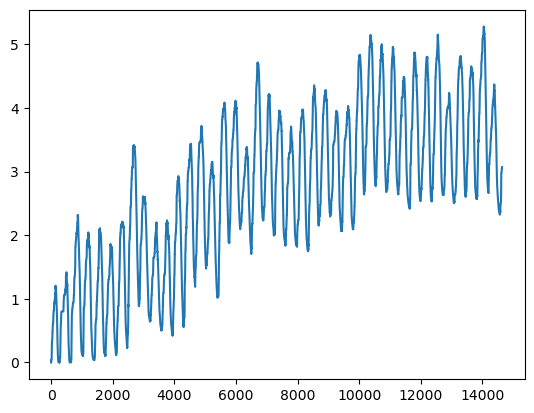

In [166]:
plt.plot(model.snow_depth_list)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


2021 Extent:  2617.8540188675934
2021 Max Ice Thickness:  151.2417176784229


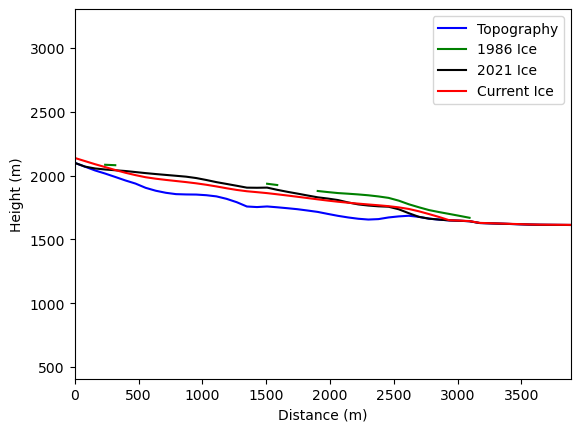

In [167]:
fig, ax = plt.subplots() #initialize plotting variables
print("2021 Extent: ",np.nanmax(model.x[model.thickness_2021_verif > 2]))
print("2021 Max Ice Thickness: ",np.nanmax(model.thickness_2021_verif))
ax.set_ylim(min(model.topo) - 100, max(model.topo) + 100)
ax.set_xlim(0, float(model.valley_length))
ax.set_ylabel("Height (m)")
ax.set_xlabel("Distance (m)")
ax.set_aspect('equal', adjustable='datalim')
ax.plot(model.x, model.topo, color="b", label="Topography")
ax.plot(model.x,model.thickness_1986_verif+model.topo, color="g", label="1986 Ice")
ax.plot(model.x,model.thickness_2021_verif+model.topo, color="black", label="2021 Ice")
ax.plot(model.x, model.ice+model.topo, color="r", label="Current Ice")
ax.legend()
plt.show()

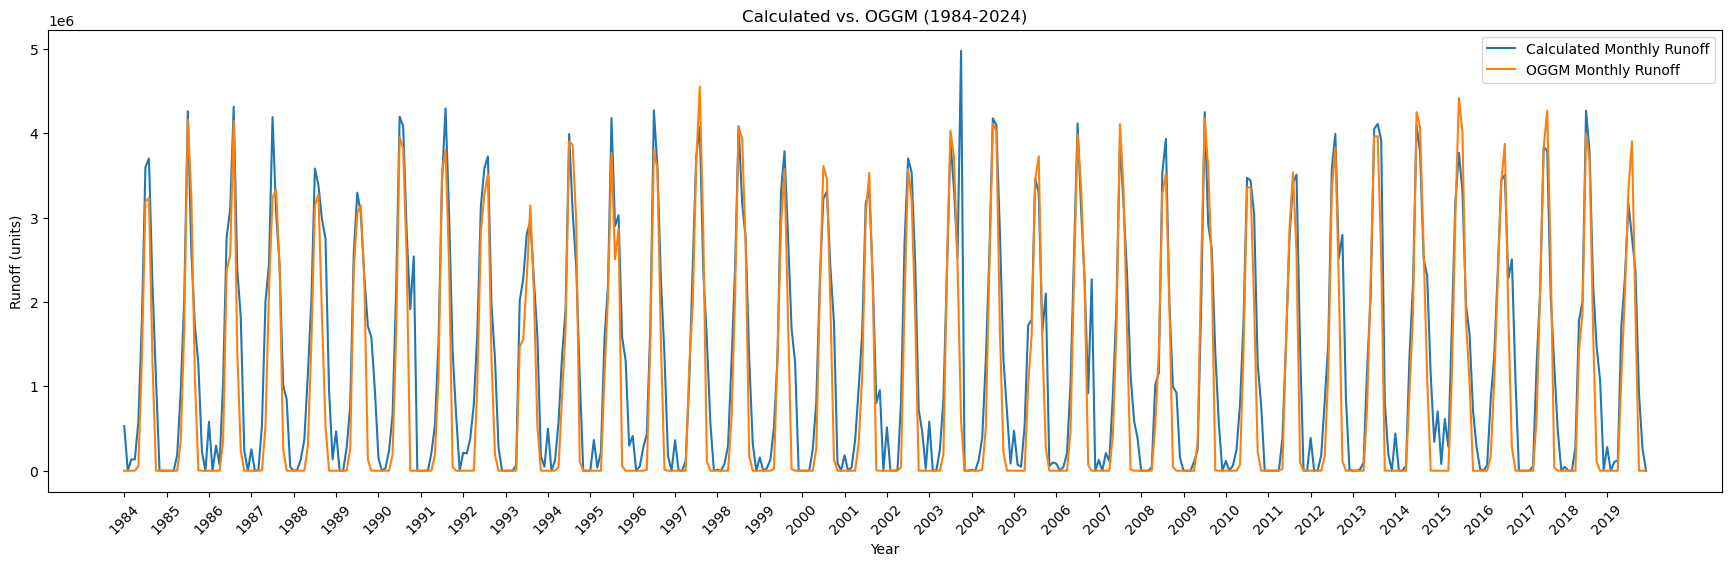

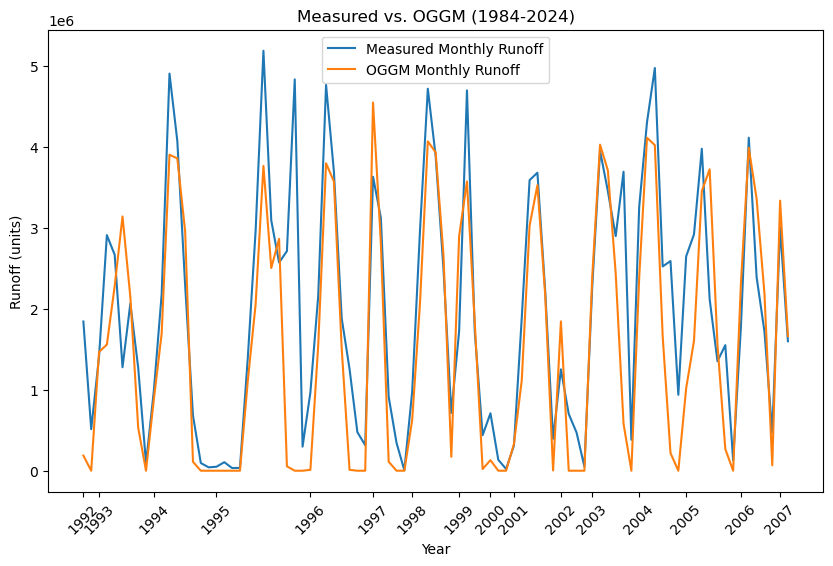

MSE of Calculated vs. OGGM:  0.015500661002631547
MSE of Measured vs. OGGM:  0.03582005194999364


Text(0.5, 1.0, 'MSE of Calculated vs. OGGM Monthly Runoff')

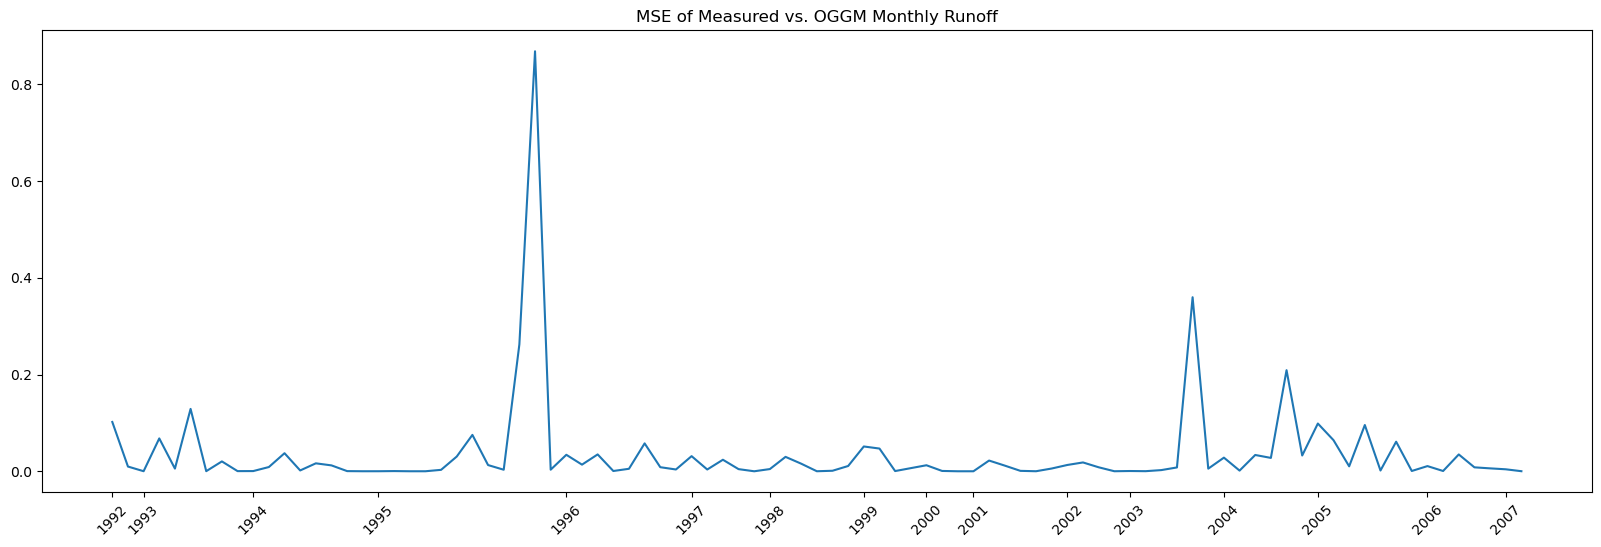

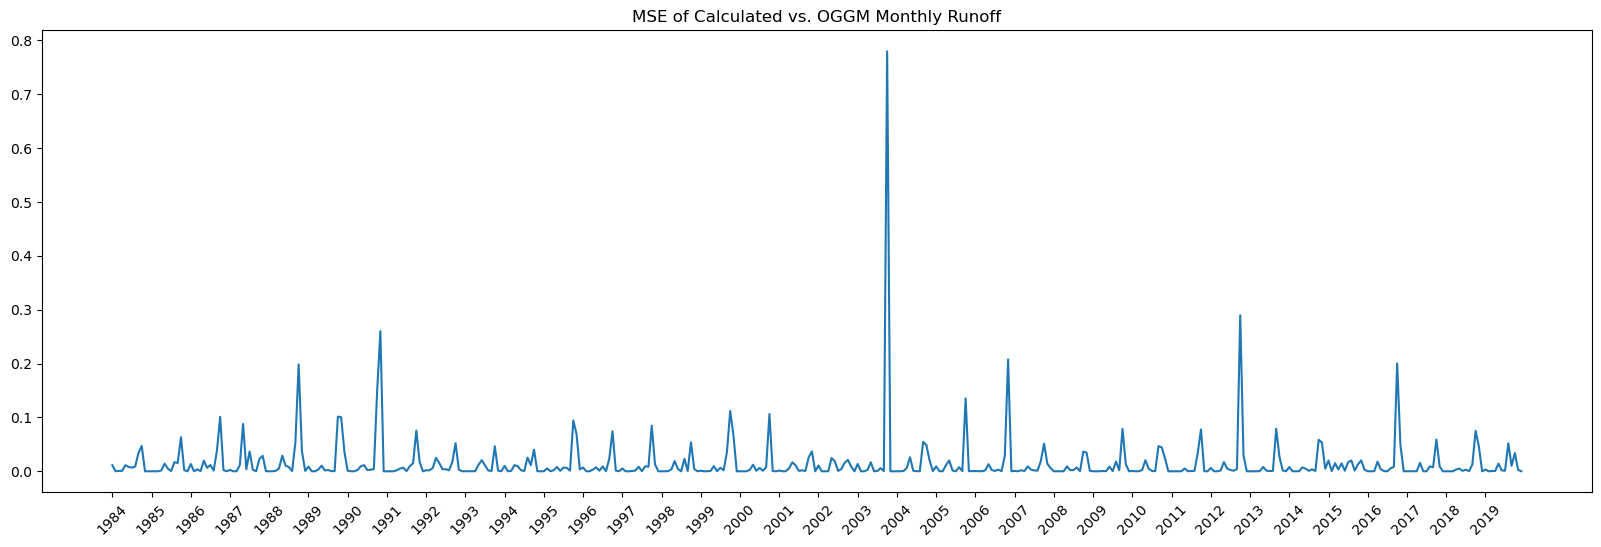

In [176]:
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_all.keys())),'volume_change': model.daily_runoff_all_data})
df['date'] = df['date'].dt.to_period('M')
monthly_volume_change_all=df.groupby('date')['volume_change'].sum().to_numpy()
month_labels_all = df['date'].dt.strftime('%m/%Y').unique()
df_oggm = pd.read_csv('Data/oggm_runoff_monthly.csv', index_col=0, parse_dates=True)
df_oggm.index = df_oggm.index.to_period('M')
df_oggm_filtered = df_oggm[df_oggm.index.isin(pd.to_datetime(pd.Series(list(model.date_index_all.keys()))).dt.to_period('M').unique())]
month_labels_oggm = df_oggm.index.strftime('%Y-%m').tolist()
oggm_runoff_monthly=df_oggm['melt_on_glacier_monthly'].to_numpy()
oggm_runoff_monthly_filtered=df_oggm_filtered['melt_on_glacier_monthly'].to_numpy()
years_array = df_oggm.index.year.values  # e.g. array([1984, 1984, 1984, ..., 2024, ...])
# Identify the unique years and choose the first occurrence in the index for each year
unique_years = np.unique(years_array)
tick_positions = []
tick_labels = []
for year in unique_years:
    # Find the first index where the year occurs
    pos = np.where(years_array == year)[0][0]
    tick_positions.append(pos)
    tick_labels.append(str(year))
fig, ax = plt.subplots(figsize=(max(10, len(tick_labels) * 0.6), 6))
ax.plot(model.monthly_runoff_all[:-49], label='Calculated Monthly Runoff')
# ax.plot(model.measured_runoff_all, label='Measured Monthly Runoff')
ax.plot(oggm_runoff_monthly, label='OGGM Monthly Runoff')
ax.set_xlabel('Year')
ax.set_ylabel('Runoff (units)')
ax.set_title('Calculated vs. OGGM (1984-2024)')
# ax.set_xticks(ticks=np.arange(len(month_labels_oggm)), labels=month_labels_oggm, rotation=45)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.legend()
plt.show()
years_array = df_oggm_filtered.index.year.values  # e.g. array([1984, 1984, 1984, ..., 2024, ...])
# Identify the unique years and choose the first occurrence in the index for each year
unique_years = np.unique(years_array)
tick_positions = []
tick_labels = []
for year in unique_years:
    # Find the first index where the year occurs
    pos = np.where(years_array == year)[0][0]
    tick_positions.append(pos)
    tick_labels.append(str(year))
fig, ax = plt.subplots(figsize=(max(10, len(tick_labels) * 0.6), 6))
ax.plot(model.measured_runoff_all, label='Measured Monthly Runoff')
# ax.plot(model.measured_runoff_all, label='Measured Monthly Runoff')
ax.plot(oggm_runoff_monthly_filtered, label='OGGM Monthly Runoff')
ax.set_xlabel('Year')
ax.set_ylabel('Runoff (units)')
ax.set_title('Measured vs. OGGM (1984-2024)')
# ax.set_xticks(ticks=np.arange(len(month_labels_oggm)), labels=month_labels_oggm, rotation=45)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.legend()
plt.show()
calculated_monthly_runoff_1984_2019=model.monthly_runoff_all[:-49]
all_min=min(np.nanmin(calculated_monthly_runoff_1984_2019),np.nanmin(oggm_runoff_monthly))
all_max=max(np.nanmax(calculated_monthly_runoff_1984_2019),np.nanmax(oggm_runoff_monthly))
monthly_volume_change_all_normalized = (calculated_monthly_runoff_1984_2019-all_min)/(all_max-all_min)
oggm_runoff_monthly_normalized= (oggm_runoff_monthly-all_min)/(all_max-all_min)
print("MSE of Calculated vs. OGGM: ", np.mean((monthly_volume_change_all_normalized-oggm_runoff_monthly_normalized)**2))
all_min=min(np.nanmin(model.measured_runoff_all),np.nanmin(oggm_runoff_monthly_filtered))
all_max=max(np.nanmax(model.measured_runoff_all),np.nanmax(oggm_runoff_monthly_filtered))
measured_runoff_all_normalized= (model.measured_runoff_all-all_min)/(all_max-all_min)
oggm_runoff_monthly_filtered_normalized= (oggm_runoff_monthly_filtered-all_min)/(all_max-all_min)
print("MSE of Measured vs. OGGM: ", np.mean((measured_runoff_all_normalized-oggm_runoff_monthly_filtered_normalized)**2))
fig,ax  = plt.subplots(figsize=(20, 6))
ax.plot((measured_runoff_all_normalized-oggm_runoff_monthly_filtered_normalized)**2)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_title("MSE of Measured vs. OGGM Monthly Runoff")
years_array = df_oggm.index.year.values
unique_years = np.unique(years_array)
tick_positions = []
tick_labels = []
for year in unique_years:
    # Find the first index where the year occurs
    pos = np.where(years_array == year)[0][0]
    tick_positions.append(pos)
    tick_labels.append(str(year))
fig,ax  = plt.subplots(figsize=(20, 6))
ax.plot((monthly_volume_change_all_normalized-oggm_runoff_monthly_normalized)**2)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_title("MSE of Calculated vs. OGGM Monthly Runoff")


2015 extent is 2114

MSE Winter:  0.03740531938836348


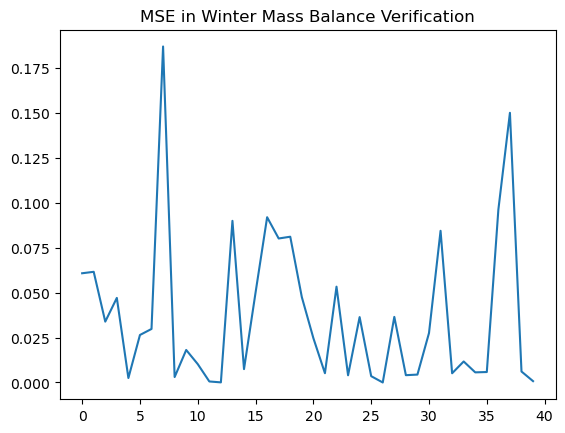

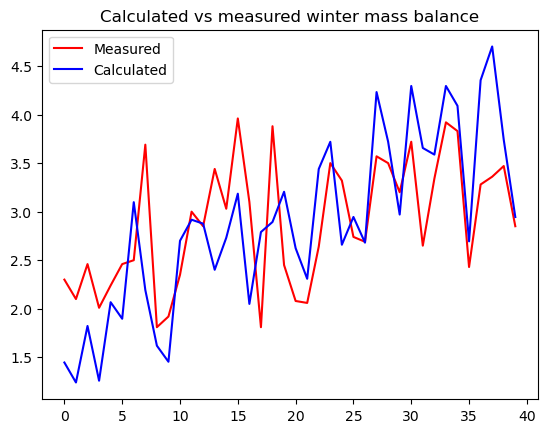

MSE Summer:  0.01674104703912433


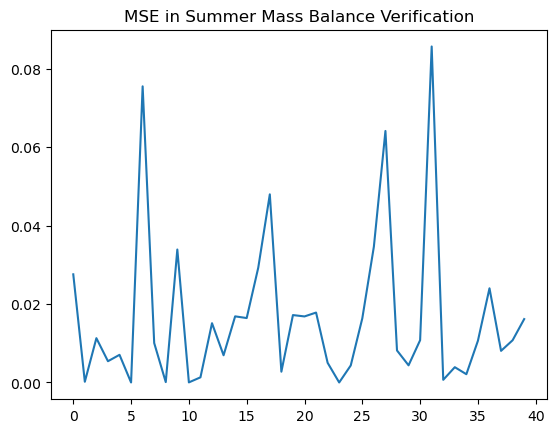

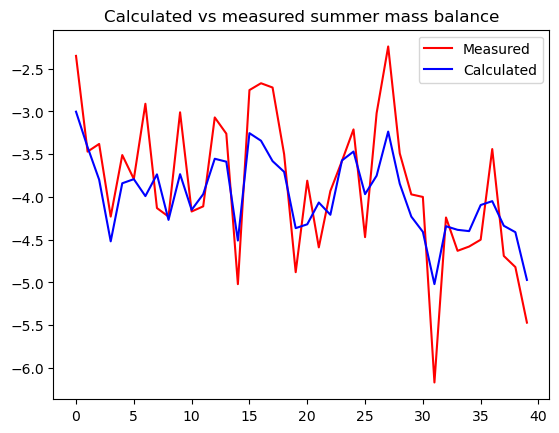

MSE Training:  0.012012221515976636
MSE Verif:  0.01605479135350426
MSE All:  0.015034622686956345
RMSE Training:  0.10960028063822025
RMSE Verif:  0.12670750314604207
RMSE All:  0.1226157521974903


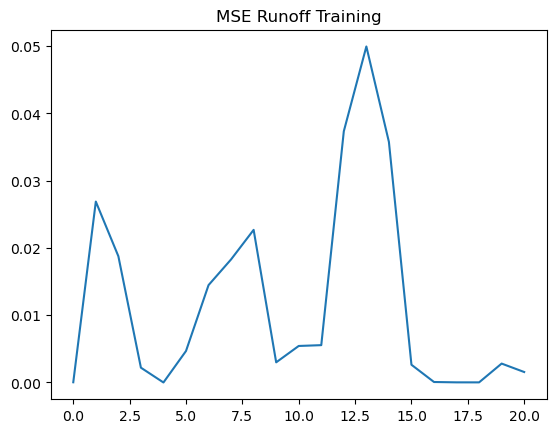

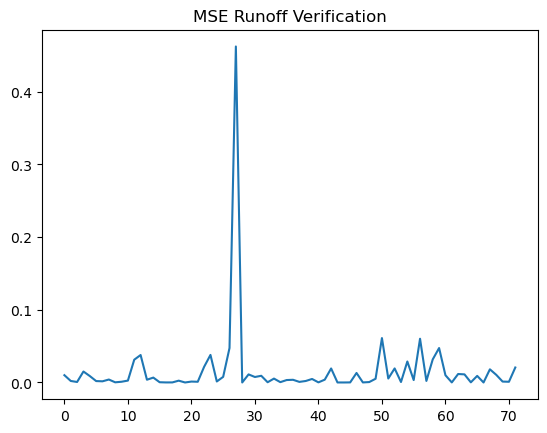

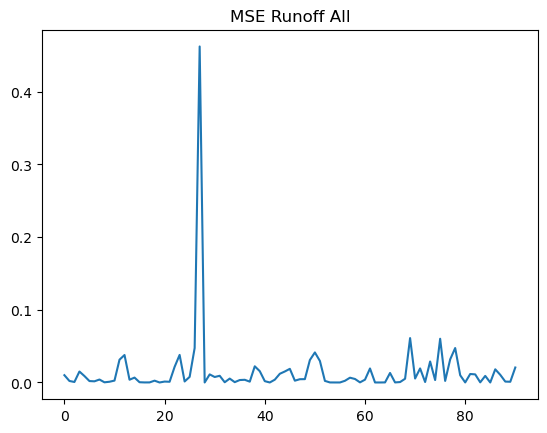

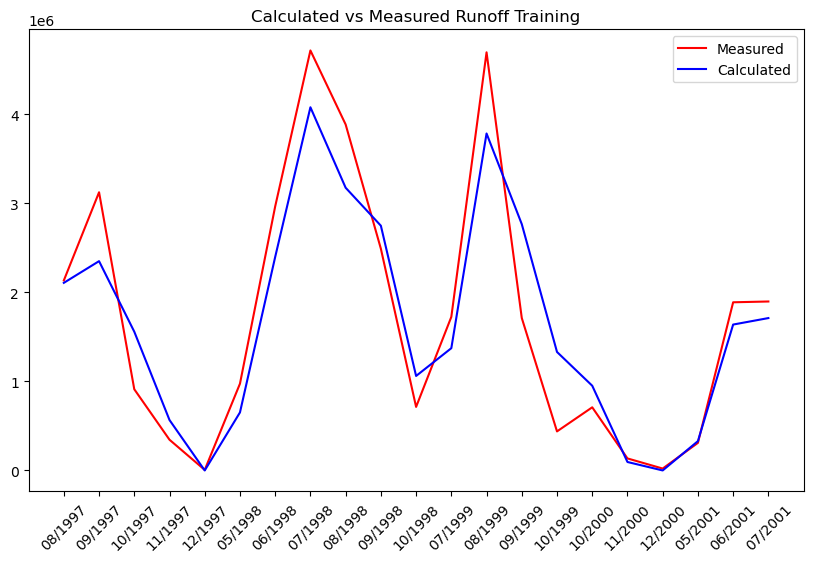

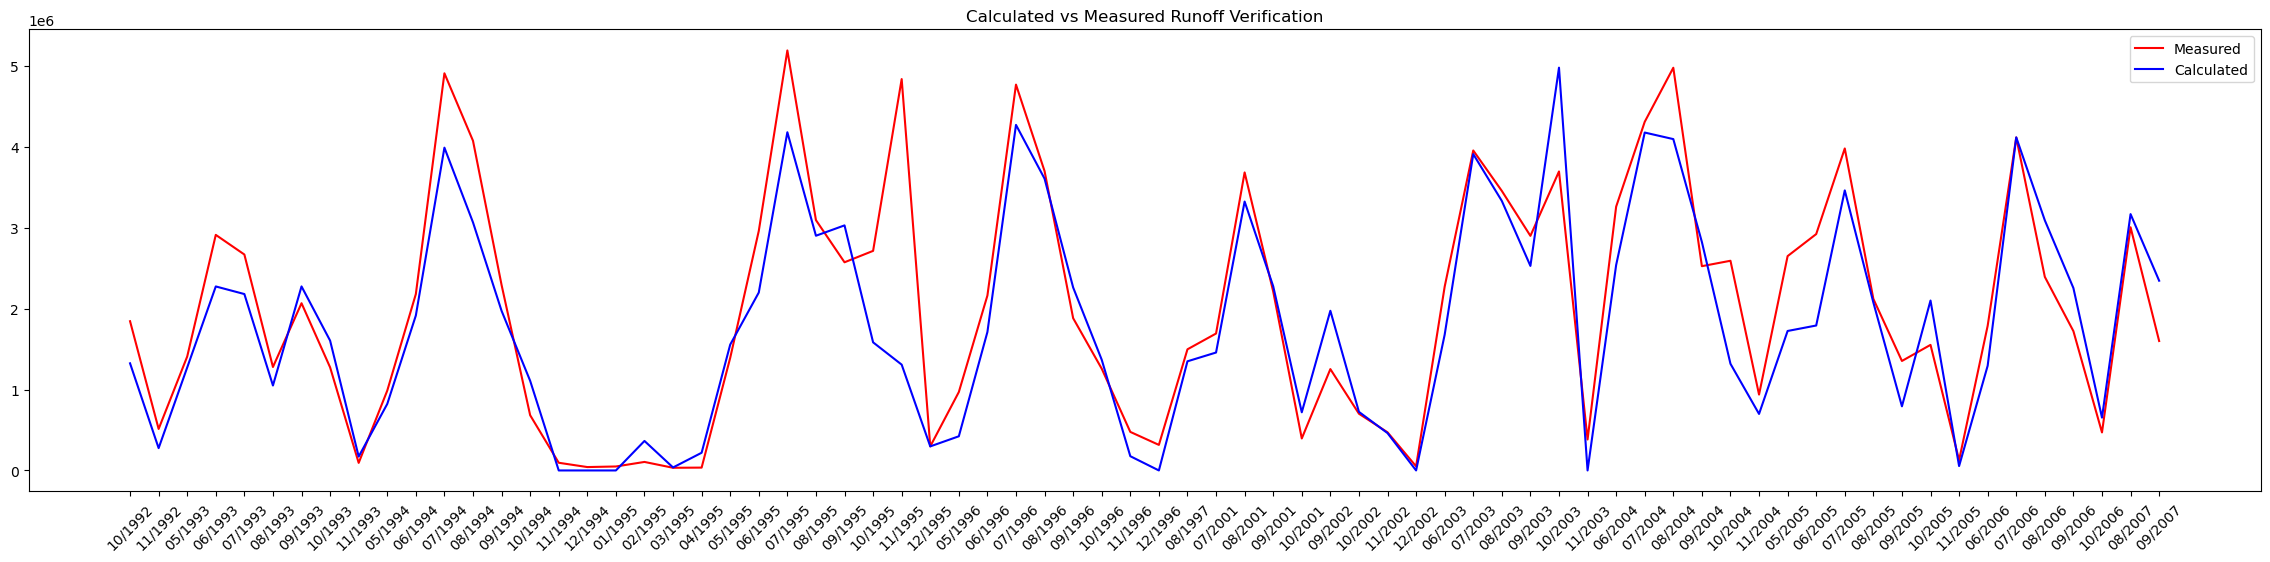

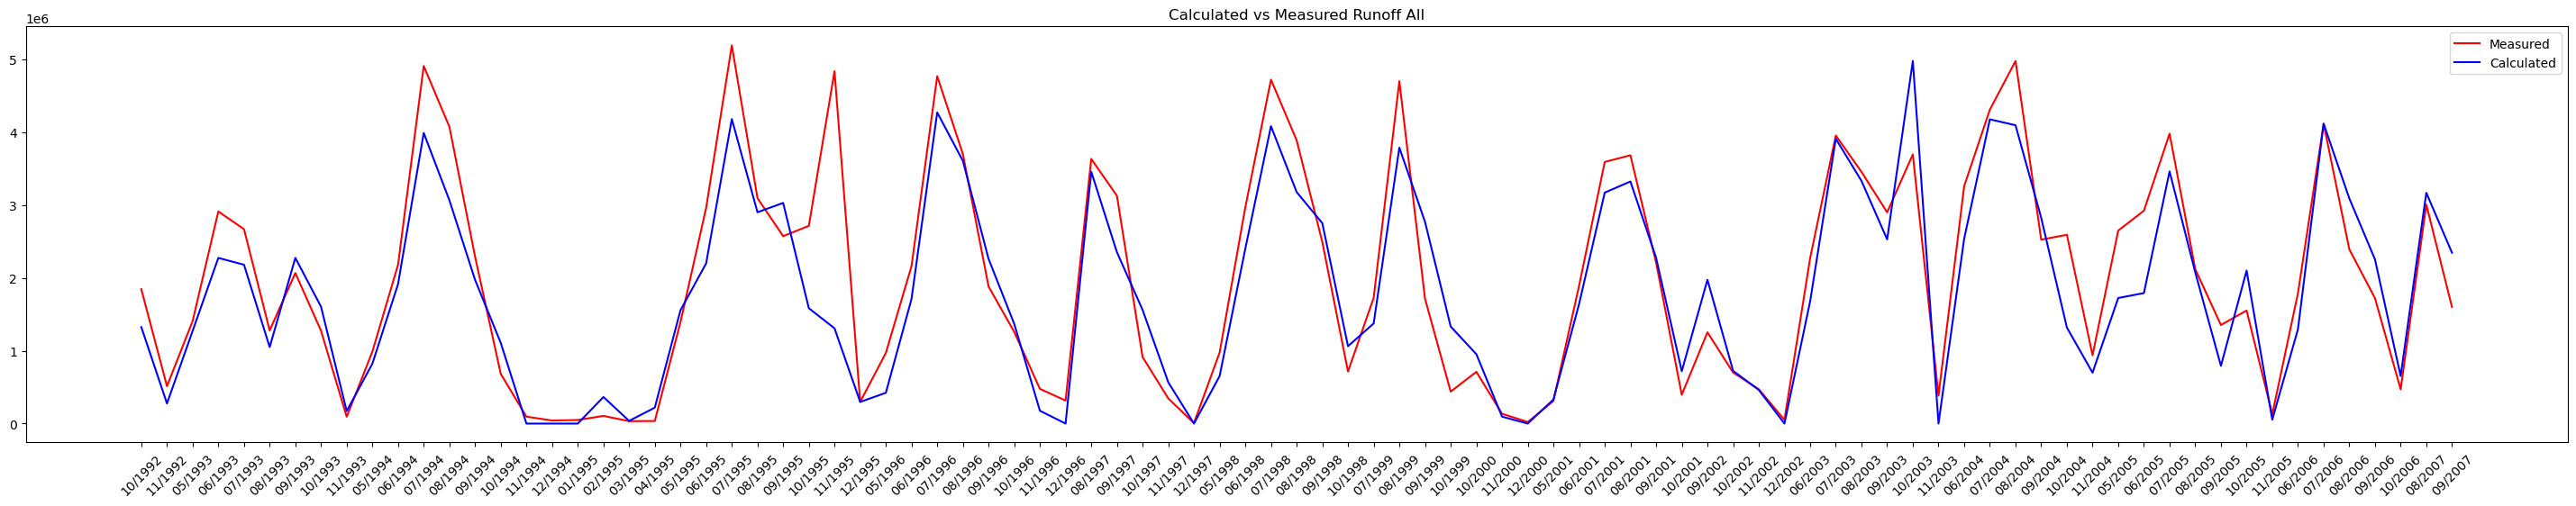

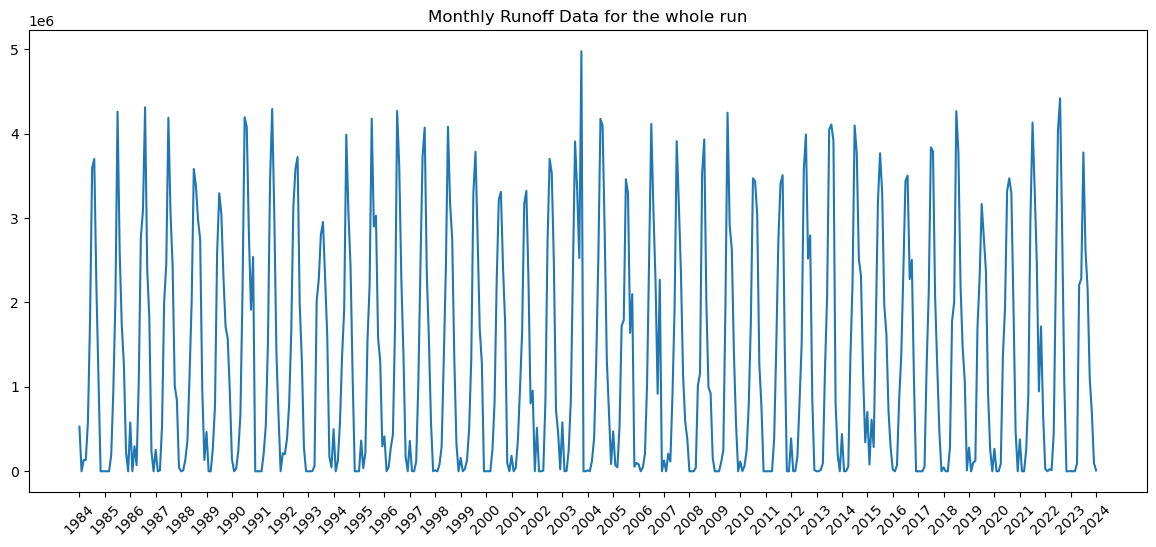

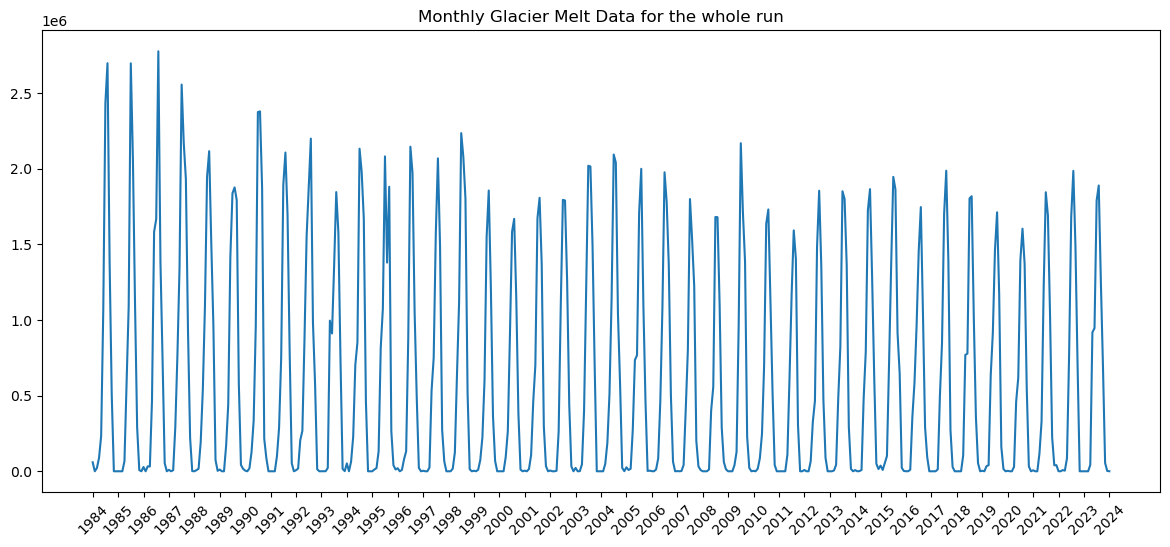

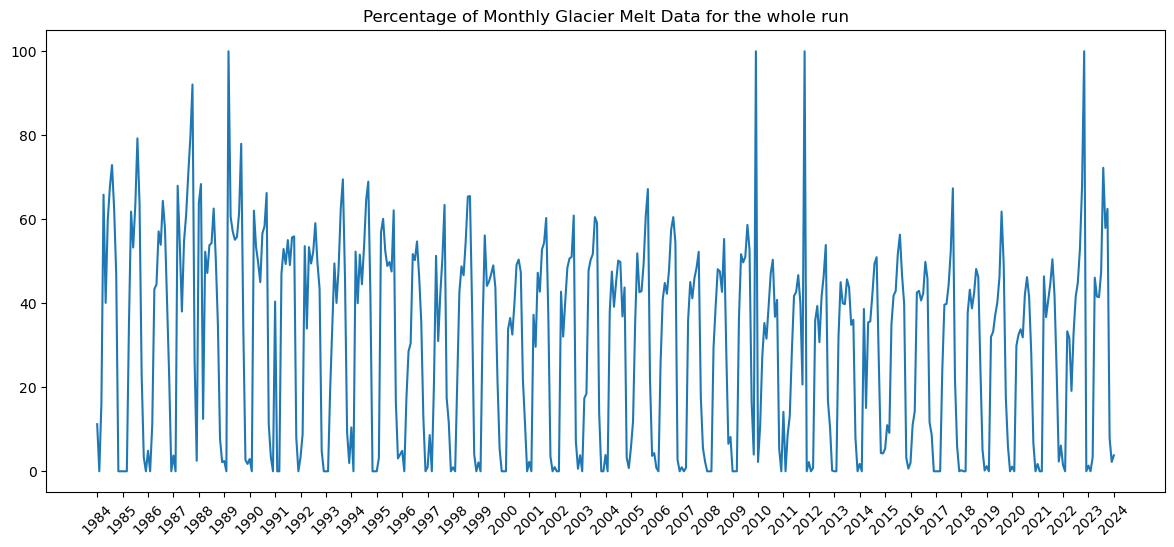

In [169]:
winter_min=min(np.nanmin(model.calculated_winter_mb),np.nanmin(model.winter_mb))
winter_max=max(np.nanmax(model.calculated_winter_mb),np.nanmax(model.winter_mb))
calc_winter_mb_norm=(model.calculated_winter_mb-winter_min)/(winter_max-winter_min)
meas_winter_mb_norm= (np.array(model.winter_mb)-winter_min)/(winter_max-winter_min)
print("MSE Winter: ", np.mean((calc_winter_mb_norm-meas_winter_mb_norm)**2))
plt.plot((calc_winter_mb_norm-meas_winter_mb_norm)**2)
plt.title("MSE in Winter Mass Balance Verification")
plt.show()
plt.plot(model.winter_mb, c='r', label="Measured")
plt.plot(model.calculated_winter_mb, c='b', label="Calculated")
plt.legend()
plt.title("Calculated vs measured winter mass balance")
plt.show()
summer_min=min(np.nanmin(model.calculated_summer_mb),np.nanmin(model.summer_mb))
summer_max=max(np.nanmax(model.calculated_summer_mb),np.nanmax(model.summer_mb))
calc_summer_mb_norm=(model.calculated_summer_mb-summer_min)/(summer_max-summer_min)
meas_summer_mb_norm= (np.array(model.summer_mb)-summer_min)/(summer_max-summer_min)
print("MSE Summer: ", np.mean((calc_summer_mb_norm-meas_summer_mb_norm)**2))
plt.plot((calc_summer_mb_norm-meas_summer_mb_norm)**2)
plt.title("MSE in Summer Mass Balance Verification")
plt.show()
plt.plot(model.summer_mb, c='r', label="Measured")
plt.plot(model.calculated_summer_mb, c='b', label="Calculated")
plt.legend()
plt.title("Calculated vs measured summer mass balance")
plt.show()
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_verif.keys())),'volume_change': model.daily_runoff_verif})
df['date'] = df['date'].dt.to_period('M')
verif_min=min(np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmin(model.measured_runoff_verif))
verif_max=max(np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmax(model.measured_runoff_verif))
monthly_volume_change_verif=df.groupby('date')['volume_change'].sum().to_numpy()
monthly_volume_change_verif_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-verif_min)/(verif_max-verif_min)
measured_runoff_verif_normalized= (model.measured_runoff_verif-verif_min)/(verif_max-verif_min)
month_labels_verif = df['date'].dt.strftime('%m/%Y').unique()
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_all.keys())),'volume_change': model.daily_runoff_all_data})
df['date'] = df['date'].dt.to_period('M')
all_min=min(np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmin(model.measured_runoff_all))
all_max=max(np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmax(model.measured_runoff_all))
monthly_volume_change_all=df.groupby('date')['volume_change'].sum().to_numpy()
monthly_volume_change_all_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-all_min)/(all_max-all_min)
measured_runoff_all_normalized= (model.measured_runoff_all-all_min)/(all_max-all_min)
month_labels_all = df['date'].dt.strftime('%m/%Y').unique()
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_training.keys())),'volume_change': model.daily_runoff_training})
df['date'] = df['date'].dt.to_period('M')
train_min=min(np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmin(model.measured_runoff_training))
train_max=max(np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmax(model.measured_runoff_training))
monthly_volume_change_train=df.groupby('date')['volume_change'].sum().to_numpy()
monthly_volume_change_train_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-train_min)/(train_max-train_min)
measured_runoff_train_normalized= (model.measured_runoff_training-train_min)/(train_max-train_min)
month_labels_train = df['date'].dt.strftime('%m/%Y').unique()
print("MSE Training: ", np.mean((monthly_volume_change_train_normalized-measured_runoff_train_normalized)**2))
print("MSE Verif: ", np.mean((monthly_volume_change_verif_normalized-measured_runoff_verif_normalized)**2))
print("MSE All: ", np.mean((monthly_volume_change_all_normalized-measured_runoff_all_normalized)**2))
print("RMSE Training: ", np.sqrt(np.mean((monthly_volume_change_train_normalized-measured_runoff_train_normalized)**2)))
print("RMSE Verif: ", np.sqrt(np.mean((monthly_volume_change_verif_normalized-measured_runoff_verif_normalized)**2)))
print("RMSE All: ", np.sqrt(np.mean((monthly_volume_change_all_normalized-measured_runoff_all_normalized)**2)))
plt.plot((monthly_volume_change_train_normalized-measured_runoff_train_normalized)**2)
plt.title("MSE Runoff Training")
plt.show()
plt.plot((monthly_volume_change_verif_normalized-measured_runoff_verif_normalized)**2)
plt.title("MSE Runoff Verification")
plt.show()
plt.plot((monthly_volume_change_all_normalized-measured_runoff_all_normalized)**2)
plt.title("MSE Runoff All")
plt.show()
plt.figure(figsize=(max(10, len(month_labels_train) * 0.4), 6))
plt.plot(model.measured_runoff_training, c='r', label="Measured")
plt.plot(monthly_volume_change_train, c='b', label="Calculated")
plt.title("Calculated vs Measured Runoff Training")
plt.xticks(ticks=np.arange(len(month_labels_train)), labels=month_labels_train, rotation=45)
plt.legend()
plt.show()
plt.figure(figsize=(max(10, len(month_labels_verif) * 0.4), 6))
plt.plot(model.measured_runoff_verif, c='r', label="Measured")
plt.plot(monthly_volume_change_verif, c='b', label="Calculated")
plt.title("Calculated vs Measured Runoff Verification")
plt.xticks(ticks=np.arange(len(month_labels_verif)), labels=month_labels_verif, rotation=45)
plt.legend()
plt.show()
plt.figure(figsize=(max(10, len(month_labels_all) * 0.4), 6))
plt.plot(model.measured_runoff_all, c='r', label="Measured")
plt.plot(monthly_volume_change_all, c='b', label="Calculated")
plt.title("Calculated vs Measured Runoff All")
plt.xticks(ticks=np.arange(len(month_labels_all)), labels=month_labels_all, rotation=45)
plt.legend()
plt.show()
monthly_runoff_all_year_labels = [str(1984 + i // 12) if i % 12 == 0 else '' for i in range(len(model.monthly_runoff_all))] 
plt.figure(figsize=(max(10, len(monthly_runoff_all_year_labels) * 0.03), 6))
plt.plot(model.monthly_runoff_all)
plt.title("Monthly Runoff Data for the whole run")
plt.xticks(ticks=[i for i, label in enumerate(monthly_runoff_all_year_labels) if label], labels=[label for label in monthly_runoff_all_year_labels if label], rotation=45)
plt.show()
monthly_glacier_melt_year_labels = [str(1984 + i // 12) if i % 12 == 0 else '' for i in range(len(model.monthly_glacier_melt))] 
plt.figure(figsize=(max(10, len(monthly_glacier_melt_year_labels) * 0.03), 6))
plt.plot(model.monthly_glacier_melt)
plt.title("Monthly Glacier Melt Data for the whole run")
plt.xticks(ticks=[i for i, label in enumerate(monthly_glacier_melt_year_labels) if label], labels=[label for label in monthly_glacier_melt_year_labels if label], rotation=45)
plt.show()
monthly_percent_glacier_melt_labels = [str(1984 + i // 12) if i % 12 == 0 else '' for i in range(len(model.monthly_glacier_melt))] 
plt.figure(figsize=(max(10, len(monthly_percent_glacier_melt_labels) * 0.03), 6))
percentage=model.monthly_glacier_melt/np.maximum(model.monthly_runoff_all,1)*100
plt.plot(percentage)
plt.title("Percentage of Monthly Glacier Melt Data for the whole run")
plt.xticks(ticks=[i for i, label in enumerate(monthly_percent_glacier_melt_labels) if label], labels=[label for label in monthly_percent_glacier_melt_labels if label], rotation=45)
plt.show()

Compute Lapse Rate

In [170]:
input_file_path = "Data/Input_SouthCascade_Daily_Weather.csv"
southcascade_file_path = "C:/Users/bookn/Downloads/Senior-Thesis/Data/SouthCascadeData/benchmarkGlacier_weather/southCascade/LVL2/southcascade1830_daily_LVL2.csv"

# Load the CSV files with date parsing
df_input = pd.read_csv(input_file_path, parse_dates=['Date'])
df_southcascade = pd.read_csv(southcascade_file_path, parse_dates=['Date'])

# Merge data on the date column
df_merged = pd.merge(df_input, df_southcascade, on='Date', how='inner')

# Compute lapse rate (temperature difference per unit elevation)
df_merged['lapse_rate'] = (df_merged['site_temp_WMO'] - df_merged['Temperature']) / (1830 - 272)

# Compute monthly average lapse rate
df_merged['month'] = df_merged['Date'].dt.to_period("M")
monthly_avg_lapse_rate = df_merged.groupby('month')['lapse_rate'].mean().reset_index()
monthly_avg_lapse_rate = monthly_avg_lapse_rate.dropna()
monthly_avg_lapse_rate.to_csv("monthly_avg_lapse_rate.csv", index=False)
monthly_avg_lapse_rate["month_number"] = monthly_avg_lapse_rate["month"].dt.month
monthly_avg_lapse_rate["year"] = monthly_avg_lapse_rate["month"].dt.year
average_lapse_rate_by_month = monthly_avg_lapse_rate.groupby("month_number")["lapse_rate"].mean().to_numpy()
average_lapse_rate_by_year= monthly_avg_lapse_rate.groupby("year")["lapse_rate"].mean().to_numpy()
print(average_lapse_rate_by_year)
print(average_lapse_rate_by_month)
print(np.mean(monthly_avg_lapse_rate['lapse_rate'].to_numpy()))
print(monthly_avg_lapse_rate)

[-0.00481836 -0.00488954 -0.00528153 -0.00750143 -0.00502926 -0.00585656
 -0.0048163  -0.00434447 -0.00489679]
[-0.00334774 -0.00544884 -0.00577458 -0.00679377 -0.00661499 -0.00627995
 -0.00529508 -0.00534911 -0.00495446 -0.00494315 -0.00472614 -0.00452499]
-0.005256829543144766
      month  lapse_rate  month_number  year
0   2010-07   -0.004863             7  2010
1   2010-08   -0.005748             8  2010
2   2010-09   -0.005466             9  2010
3   2010-10   -0.004236            10  2010
4   2010-11   -0.004444            11  2010
..      ...         ...           ...   ...
90  2018-01   -0.002933             1  2018
91  2018-02   -0.004776             2  2018
92  2018-03   -0.004935             3  2018
93  2018-04   -0.006192             4  2018
94  2018-05   -0.005648             5  2018

[79 rows x 4 columns]


In [171]:
# df = pd.read_csv('Data/Input_SouthCascade_Daily_Weather.csv')
# dates = pd.to_datetime(df.iloc[:, 0], format="%Y/%m/%d").tolist()
# temps = df.iloc[:, 1].astype(float).to_numpy()
# precip = df.iloc[:, 2].apply(lambda x: float(x) if not np.isnan(float(x)) else 0).to_numpy()
# df = pd.read_csv('Data/Output_SouthCascade_Glacier_Wide_solutions_calibrated.csv', skiprows=25)
# annual_mb = df.iloc[:-1, 3].astype(float).tolist()
# summer_mb = df.iloc[:-1, 2].astype(float).tolist()
# winter_mb = df.iloc[:-1, 1].astype(float).tolist()
# lapse_rate=0.0065
# glac_temps=temps-lapse_rate*(1700-272)
# snow=precip[glac_temps<0]/1000
# #snow=precip/1000
# dates = [dates[i] for i in range(len(dates)) if glac_temps[i] < 0]
# snow_df = pd.DataFrame({'date': dates, 'snow': snow})
# snow_df = snow_df[snow_df['date'].dt.year != 2024]
# snow_year = snow_df.groupby(snow_df['date'].dt.year)['snow'].sum().to_numpy()
# print(snow_year)
# print(winter_mb)
# print(np.mean(np.array(winter_mb)/np.array(snow_year)))
# print(np.std(np.array(winter_mb)/np.array(snow_year)))
# plt.plot(snow_year*1.7, c='b')
# plt.plot(winter_mb, c='r')
# plt.show()
# plt.plot(np.array(winter_mb)/np.array(snow_year))
# plt.show()
# plt.plot(winter_mb, c='b')
# plt.plot(np.array(snow_year)*(np.mean(np.array(winter_mb)/np.array(snow_year))), c='r')
# plt.show()
# plt.plot((np.array(snow_year)*(np.mean(np.array(winter_mb)/np.array(snow_year)))-winter_mb)/winter_mb*100)


Plots the widths

In [172]:
# fig, ax = plt.subplots()
# _ = plt.close(fig) #used to prevent an empty plot from displaying
# # Initialize a line object
# line, = ax.plot([], [], 'b-')
# # Create a ScalarMappable for the color bar
# norm = plt.Normalize(vmin=0, vmax=np.max(model.ice_thickness_over_time))
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])

# # Add the color bar to the figure
# cbar = fig.colorbar(sm, ax=ax)
# # Define the update function
# def update(frame):
#     ax.clear()
#     ax.set_xlim(0,float(model.valley_length))
#     ax.set_ylim(-1000, 1000)
#     ax.set_aspect('equal', adjustable='datalim')
#     ax.set_ylabel("Width (m)")
#     ax.set_xlabel("Distance (m)")
#     if start_time==500: ax.set_title(f"Time: {frame + 1984}")
#     else: ax.set_title(f"Time: {frame + 1950}")
#     half_widths = model.widths_over_time[frame] / 2
#     ax.plot(model.x, half_widths, 'b-')  # Plot the positive half
#     ax.plot(model.x, -half_widths, 'b-')  # Plot the negative half
#     color = plt.cm.viridis(model.ice_thickness_over_time[frame] / np.max(model.ice_thickness_over_time))  # Normalize ice thickness for colormap
#     for i in range(len(model.x) - 1):
#         ax.fill_between(model.x[i:i+2], half_widths[i:i+2], -half_widths[i:i+2], color=color[i])
#     return line,
# #plt.plot((np.arange(0,model.time+model.save, model.save)), model.volume_change)
# # Create the animation
# anim2 = FuncAnimation(fig, update, frames=len(model.widths_over_time), blit=False, repeat=False)
# # Display the animation
# vid2 = HTML(anim2.to_jshtml())
# display(vid2)

In [173]:
# ela=1880
# ela_1900=1930
# time=540
# start_time=500
# save=1 #Needs to be 1 for the ela_list to work properly
# gamma=0.016
# quiet=True
# # accumfactor=0.004731588686211069*1.2
# # ice_meltfactor=-0.008472259912843966
# # snow_meltfactor= -0.0036515609274413875
# # snow_conv_factor=  5.310488160176582*1.2
# # snow_melt_amplitude= -0.005747189439663826
# # ice_melt_amplitude=  -0.002254212082875086
# #Note: One of the papers I found had snow_meltfactor around 0.004 and ice_meltfactor around 0.006. 
# # This is in meters water equivalent per positive degree day, NOT PER DEGREE C
# # accumfactor=0.0319 #bounds approx 0.001-0.005
# # accumfactor=1.7
# accumfactor_lower=1.2
# accumfactor_upper=2.5
# #-0.0035 for both minimizes summer mb diff
# ice_meltfactor= -0.0044 #bounds approx 0.005-0.012
# snow_meltfactor=-0.002 #bounds approx 0.002-0.006
# #mse optimized:8.94, rmse same
# snow_conv_factor=9.03#bounds 5-15
# # lapse_rate=0.007
# lapse_rate=[-0.00334774, -0.00544884, -0.00577458, -0.00679377, -0.00661499, -0.00627995, -0.00529508, -0.00534911, -0.00495446, -0.00494315, -0.00472614, -0.00452499]
# tune_factors=[ice_meltfactor,snow_meltfactor,lapse_rate,accumfactor_lower,accumfactor_upper,snow_conv_factor]
# #tune_factors=[-6.21530477e-03, -3.16373793e-03,  3.90806503e-03,  6.37238199e+00,-5.37087541e-03,-1.14816075e-03]
# # tune_factors=[ice_meltfactor, snow_meltfactor, accumfactor, snow_conv_factor,snow_melt_amplitude,ice_melt_amplitude,lapse_rate]
# #tune_factors=[-7.94739209e-03 ,-8.02449065e-03 , 1.04047812e-02,  9.01413327e+00,-7.81444522e-04, -9.97332457e-04]
# ice = [ 53.89550985, 61.2302675, 68.52805603, 72.16752233, 78.19477103,
# 86.57434438, 94.52278703, 113.00567764, 124.65045342, 131.1336047,
# 132.61805723, 126.05975829, 117.01403765, 110.72201024, 107.36448442,
# 113.23158091, 127.19316445, 150.80920841, 147.75800077, 135.19461921,
# 132.62404257, 130.58089845, 128.95030221, 129.67226275, 131.1275745,
# 137.76555425, 144.54125286, 149.5876901, 152.88274456, 152.52189309,
# 142.71479768, 122.66643947, 105.65745331, 89.73132543, 84.64598526,
# 84.39967405, 78.27781775, 70.24575207, 57.81117783, 43.58883439,
# 34.64893057, 15.29705107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
# best_accum_lower=0
# best_accum_upper=0
# best_ice_meltfactor=0
# best_snow_meltfactor=0
# min_result_winter=inf
# min_result_summer=inf
# accum_lower_list=np.arange(1,1.51,0.01)
# accum_upper_list=np.arange(1.5,2.01,0.01)
# ice_meltfactor_list=np.arange(-0.005,-0.002,0.0001)
# snow_meltfactor_list=np.arange(-0.005,-0.002,0.0001)
# checked_ice_list=[]
# checked_snow_list=[]
# ice_index=0
# snow_index=0
# for accum_upper in accum_upper_list:
#     for accum_lower in accum_lower_list:
#         ice_meltfactor=ice_meltfactor_list[ice_index]
#         snow_meltfactor=snow_meltfactor_list[snow_index]
#         checked_ice_list.append(ice_meltfactor)
#         checked_snow_list.append(snow_meltfactor)
#         tune_factors=[ice_meltfactor,snow_meltfactor,lapse_rate,accum_lower,accum_upper,snow_conv_factor]
#         model = glacierSim(ela=ela, ela_1900=ela_1900,time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
#         model.init(ax,ela=ela, ela_1900=ela_1900,time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
#         for i in range(0,model.frames):
#             model.run_model(i)
#         summer_min=min(np.nanmin(model.calculated_summer_mb),np.nanmin(model.summer_mb))
#         summer_max=max(np.nanmax(model.calculated_summer_mb),np.nanmax(model.summer_mb))
#         calc_summer_mb_norm=(model.calculated_summer_mb-summer_min)/(summer_max-summer_min)
#         meas_summer_mb_norm= (np.array(model.summer_mb)-summer_min)/(summer_max-summer_min)
#         if(np.mean((calc_summer_mb_norm-meas_summer_mb_norm)**2)<min_result_summer):
#             min_result_summer=np.mean((calc_summer_mb_norm-meas_summer_mb_norm)**2)
#             best_ice_meltfactor=ice_meltfactor
#             best_snow_meltfactor=snow_meltfactor
#         winter_min=min(np.nanmin(model.calculated_winter_mb),np.nanmin(model.winter_mb))
#         winter_max=max(np.nanmax(model.calculated_winter_mb),np.nanmax(model.winter_mb))
#         calc_winter_mb_norm=(model.calculated_winter_mb-winter_min)/(winter_max-winter_min)
#         meas_winter_mb_norm= (np.array(model.winter_mb)-winter_min)/(winter_max-winter_min)
#         if (np.mean((calc_winter_mb_norm-meas_winter_mb_norm)**2)<min_result_winter):
#             min_result_winter=np.mean((calc_winter_mb_norm-meas_winter_mb_norm)**2)
#             best_accum_lower=accum_lower
#             best_accum_upper=accum_upper
#         if snow_index<len(snow_meltfactor_list): snow_index+=1
#     if ice_index<len(ice_meltfactor_list): ice_index+=1